In [1]:
# Load Dataset

import torch
dataset = torch.load("../torchfem_dataset/panel_plasticity_3/panel_combined_4.pt",weights_only=False)
#dataset_2 = torch.load("../torchfem_dataset/tube_2/tube_combined.pt",weights_only=False)

In [2]:
## Process dataset for training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data, dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes â†’ u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int#, data['nodes'].pos
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts

    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        elem_s = torch.cat([d['elements'].y_s.float() for d in dataset],dim=0)
        node_pos = torch.cat([d['nodes'].pos.float() for d in dataset], dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    e = data[etype].edge_attr.float()
                    self.edge_stats[etype] = {
                        "mean": e.mean(dim=0, keepdim=True),
                        "std":  e.std(dim=0, keepdim=True) + 1e-8}
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            "mean": node_u.mean(dim=0, keepdim=True),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['elem_s'] = {
            "mean": elem_s.mean(dim=0, keepdim=True),
            "std":  elem_s.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_pos'] = {
            "mean": node_pos.mean(dim=0,keepdim=True),
            "std": node_pos.std(dim=0,keepdim=True) + 1e-8}
        

        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x
        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u
        y_s = data['elements'].y_s.float()
        m_s = self.node_stats['elem_s']["mean"]
        s_s = self.node_stats['elem_s']["std"]
        data['elements'].y_s = (y_s - m_s) / s_s
        pos = data['nodes'].pos.float()
        m_p = self.node_stats['nodes_pos']['mean']
        s_p = self.node_stats['nodes_pos']['std']
        data['nodes'].pos = (pos-m_p)/s_p

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: HeteroData, fields=("nodes_x","nodes_f","nodes_u","elem_s")):
        # Nodes
        if "nodes_x" in fields:
            m, s = self.node_stats["nodes_x"]["mean"], self.node_stats["nodes_x"]["std"]
            data["nodes"].x[:, 3:] = data["nodes"].x[:, 3:] * s + m
        if "nodes_f" in fields:
            m, s = self.node_stats["nodes_f"]["mean"], self.node_stats["nodes_f"]["std"]
            data["nodes"].y_fint = data["nodes"].y_fint * s + m
        if "nodes_u" in fields:
            m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
            data["nodes"].y_u = data["nodes"].y_u * s + m
        if "elem_s" in fields:
            m, s = self.node_stats["elem_s"]["mean"], self.node_stats["elem_s"]["std"]
            data["elements"].y_s = data["elements"].y_s * s + m
        if "nodes_pos" in fields:
            m, s = self.node_stats["nodes_pos"]["mean"], self.node_stats["nodes_pos"]["std"]
            data["nodes"].pos = data["nodes"].pos * s + m

        # Edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                m, s = self.edge_stats[etype]["mean"], self.edge_stats[etype]["std"]
                data[etype].edge_attr = data[etype].edge_attr * s + m
        return data

scaler = HeteroStandardScaler()

## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in dataset]
scaler.fit(dataset_p)
dataset_t = [scaler.transform(d) for d in dataset_p]

def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)


In [4]:
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)
print(train_set[10])

HeteroData(
  nodes={
    fext=[10400, 3],
    x=[10400, 6],
    y_u=[10400, 3],
    y_fint=[10400, 3],
  },
  elements={
    num_nodes=7936,
    x=[7936, 4],
    y_s=[7936, 9],
  },
  (elements, contributes, nodes)={
    edge_index=[2, 63488],
    edge_attr=[63488, 7],
  },
  (nodes, belongs_to, elements)={
    edge_index=[2, 63488],
    edge_attr=[63488, 7],
  },
  (nodes, adjacent, nodes)={
    edge_index=[2, 28635],
    edge_attr=[28635, 7],
  },
  (nodes, adjacent_rev, nodes)={
    edge_index=[2, 28635],
    edge_attr=[28635, 7],
  }
)


In [3]:
## Graclus pooling helper (homogenize -> pool -> de-homogenize)

import torch
from torch_geometric.data import Data
from torch_geometric.nn.pool import graclus
from torch_geometric.utils import coalesce
from torch_scatter import scatter_mean, scatter_max
import torch_cluster


def graclus_pool_hetero(data):
    """
    Pools a HeteroData graph with Graclus on intra-type edges, then maps back
    to hetero form. Cross-type edges are reindexed to the pooled nodes.
    Assumes each node type has features in x.
    """
    homo = data.to_homogeneous(add_node_type=True, add_edge_type=True, node_attrs=['x'])
    node_type = homo.node_type
    edge_type = homo.edge_type

    src, dst = homo.edge_index
    same_type = node_type[src] == node_type[dst]
    edge_index_intra = homo.edge_index[:, same_type]

    # If no intra-type edges, return original graph
    if edge_index_intra.numel() == 0:
        return data

    # Run Graclus on intra-type edges to avoid merging different node types
    cluster = graclus(edge_index_intra, num_nodes=homo.num_nodes)

    # Pool node features
    pooled_x = scatter_mean(homo.x, cluster, dim=0)
    # Keep the (dominant) node_type per cluster; valid when clusters are same-type
    pooled_node_type = scatter_max(node_type, cluster, dim=0)[0]

    # Reindex edges through clusters
    pooled_edge_index = cluster[homo.edge_index]
    pooled_edge_type = edge_type.clone()

    pooled_edge_index, pooled_edge_type = coalesce(
        pooled_edge_index, pooled_edge_type, m=pooled_x.size(0), n=pooled_x.size(0), reduce='min'
    )

    pooled_homo = Data(
        x=pooled_x,
        edge_index=pooled_edge_index,
        edge_type=pooled_edge_type,
        node_type=pooled_node_type,
    )

    pooled_hetero = pooled_homo.to_heterogeneous(
        node_type=pooled_homo.node_type,
        edge_type=pooled_homo.edge_type,
        node_type_names=data.node_types,
        edge_type_names=data.edge_types,
    )

    return pooled_hetero, cluster, node_type

def unpool_preds(pred_pooled, cluster, node_type, node_type_names):
    out = {}
    for t, name in enumerate(node_type_names):
        mask = (node_type == t)
        ct = cluster[mask]          # shape: num_original_nodes_of_type
        if name in pred_pooled:
            out[name] = pred_pooled[name][ct]
    return out

                 ┌─────────────────────────────────────────┐
                 │         INPUT FEATURES (FINE)           │
                 └─────────────────────────────────────────┘
                                   │
                                   ▼
                         ┌──────────────────┐
                         │  Fine Encoder    │
                         └──────────────────┘
                                   │
                             h_f (0)
                                   │
     ┌─────────────────────────────────────────────────────────────────────────┐
     │                                                                         │
     │   FINE GRAPH BRANCH (G_f)                   COARSE GRAPH BRANCH (G_c)   │
     │                                                                         │
     │                                                                         │
     │     h_f(0)                                                              │
     │       │                                                                 │
     │       ▼                                                                 │
     │   ┌───────────┐        Down/Pool        ┌───────────┐                  │
     │   │ MPNN_f[1] │ ----------------------> │ MPNN_c[1] │                  │
     │   └───────────┘                         └───────────┘                  │
     │       │                                     │                          │
     │       ▼                                     ▼                          │
     │   ┌───────────┐        Down/Pool        ┌───────────┐                  │
     │   │ MPNN_f[2] │ ----------------------> │ MPNN_c[2] │                  │
     │   └───────────┘                         └───────────┘                  │
     │       │                                     │                          │
     │       ▼                                     ▼                          │
     │   ┌───────────┐        Down/Pool        ┌───────────┐                  │
     │   │ MPNN_f[3] │ ----------------------> │ MPNN_c[3] │                  │
     │   └───────────┘                         └───────────┘                  │
     │       │                                     │                          │
     │       ▼                                     ▼                          │
     │     h_f(k)                               h_c(K)                        │
     │                                                                         │
     └─────────────────────────────────────────────────────────────────────────┘
                                   │
                        (Skip/Interpolation: Up)
                                   │
                                   ▼
                         ┌────────────────────┐
                         │   Merge Features   │
                         │   h_f + Interp(h_c)│
                         └────────────────────┘
                                   │
                                   ▼
                         ┌──────────────────┐
                         │   Fine Decoder   │
                         └──────────────────┘
                                   │
                                   ▼
                 ┌───────────────────────────────────────────┐
                 │              OUTPUT (e.g. noise,           │
                 │      displacements, stresses, fields)      │
                 └───────────────────────────────────────────┘


                          DIFFUSION STEP INPUT
    ┌────────────────────────────────────────────────────────────┐
    │   Noisy Graph State x_t  (fine mesh nodes & edges)         │
    │   Diffusion timestep t (scalar or embedding)               │
    │   Optional conditions: BCs, loads, materials, geometry      │
    └────────────────────────────────────────────────────────────┘
                                      │
                                      ▼
                             ┌────────────────┐
                             │  Fine Encoder  │
                             └────────────────┘
                                      │
                                    h_f(0)
                                      │
                                      │   (Pooling / Coarsening)
                                      ▼
                             ┌────────────────┐
                             │  Coarse Encode │
                             └────────────────┘
                                      │
                                    h_c(0)
                                      │

       =====================================================================
       ||                                                                 ||
       ||           PARALLEL MULTISCALE DIFFUSION DENOISER                ||
       ||                                                                 ||
       =====================================================================

          FINE GRAPH (G_f)                          COARSE GRAPH (G_c)
    ─────────────────────────────────       ──────────────────────────────────

            h_f(0)                                        h_c(0)
               │                                             │
               ▼                                             ▼
        ┌────────────┐       Down/Pool (P)        ┌────────────────┐
        │ MPNN_f[1]   │ -------------------------> │   MPNN_c[1]    │
        └────────────┘                              └────────────────┘
               │                                             │
               ▼                                             ▼
        ┌────────────┐       Down/Pool (P)        ┌────────────────┐
        │ MPNN_f[2]   │ -------------------------> │   MPNN_c[2]    │
        └────────────┘                              └────────────────┘
               │                                             │
               ▼                                             ▼
        ┌────────────┐       Down/Pool (P)        ┌────────────────┐
        │ MPNN_f[3]   │ -------------------------> │   MPNN_c[3]    │
        └────────────┘                              └────────────────┘
               │                                             │
               ▼                                             ▼
            h_f(K)                                        h_c(L)
               │                                             │

       =====================================================================
                               CROSS-SCALE FUSION
       =====================================================================

                   (Up/Interp) from coarse → fine
               h_f(K)  ←──────────── I(h_c(L))
                                      │
                                      ▼
                             ┌────────────────┐
                             │  Fine Decoder  │
                             └────────────────┘
                                      │
                                      ▼
                           ┌───────────────────────┐
                           │  Output: Denoised     │
                           │  ε̂θ(x_t, t, cond)    │
                           │  or Score(x_t)        │
                           └───────────────────────┘

             This feeds the diffusion sampler (DDPM, DDIM, SDE, etc.)


In [3]:
from typing import Optional
import torch
from torch import Tensor
import torch_geometric.typing

def graclus_cluster(
    row: torch.Tensor,
    col: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    num_nodes: Optional[int] = None,
) -> torch.Tensor:
    """A greedy clustering algorithm of picking an unmarked vertex and matching
    it with one its unmarked neighbors (that maximizes its edge weight).

    Args:
        row (LongTensor): Source nodes.
        col (LongTensor): Target nodes.
        weight (Tensor, optional): Edge weights. (default: :obj:`None`)
        num_nodes (int, optional): The number of nodes. (default: :obj:`None`)

    :rtype: :class:`LongTensor`

    .. code-block:: python

        import torch
        from torch_cluster import graclus_cluster

        row = torch.tensor([0, 1, 1, 2])
        col = torch.tensor([1, 0, 2, 1])
        weight = torch.Tensor([1, 1, 1, 1])
        cluster = graclus_cluster(row, col, weight)
    """

    if num_nodes is None:
        num_nodes = max(int(row.max()), int(col.max())) + 1

    # Remove self-loops.
    mask = row != col
    row, col = row[mask], col[mask]

    if weight is not None:
        weight = weight[mask]

    # Randomly shuffle nodes.
    if weight is None:
        perm = torch.randperm(row.size(0), dtype=torch.long, device=row.device)
        row, col = row[perm], col[perm]

    # To CSR.
    perm = torch.argsort(row)
    row, col = row[perm], col[perm]
    if weight is not None:
        weight = weight[perm]
    deg = row.new_zeros(num_nodes)
    deg.scatter_add_(0, row, torch.ones_like(row))
    rowptr = row.new_zeros(num_nodes + 1)
    torch.cumsum(deg, 0, out=rowptr[1:])

    return torch.ops.torch_cluster.graclus(rowptr, col, weight)


In [4]:
## Training loop with U-Net

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch_geometric.data import Data, HeteroData
#from torch_geometric.nn.pool import graclus
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import coalesce
from torch_geometric.nn.pool.pool import pool_edge, pool_pos, pool_batch
from torch_geometric.loader import DataLoader
from torch_scatter import scatter_mean
from torch_geometric.utils import to_undirected
import pandas as pd

torch.cuda.empty_cache()
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

# Build assignment matrix: fine → coarse
def build_assignment_matrix(cluster, num_clusters):
    N = cluster.numel()
    A = torch.zeros(N, num_clusters, device=cluster.device)
    A[torch.arange(N), cluster] = 1.0
    return A

def build_assignment_matrix_sparse(cluster, num_clusters):
    # cluster: [N] long, values in [0, num_clusters)
    N = cluster.numel()
    idx_rows = torch.arange(N, device=cluster.device, dtype=torch.long)
    idx_cols = cluster.long()
    indices = torch.stack([idx_rows, idx_cols])  # shape [2, nnz]
    values = torch.ones(N, device=cluster.device)
    A = torch.sparse_coo_tensor(indices, values, (N, num_clusters))
    return A.coalesce()

class MPNNBlock(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels):
        """
        Edge-aware MPNN with concatenation of (x_i, x_j, e_ij)
        """
        super().__init__(aggr='add')

        self.mlp = nn.Sequential(
            nn.Linear(2 * in_channels + edge_dim, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):
        msg = torch.cat([x_i, x_j, edge_attr], dim=-1)
        return self.mlp(msg)

    def update(self, aggr_out):
        return aggr_out


# -----------------------------
# Recompute relative edge attrs from positions
# edge_attr_geo = pos_j - pos_i
# -----------------------------
def recompute_relative_edge_attr(pos, edge_index):
    row, col = edge_index
    return pos[col] - pos[row]


# -----------------------------
# Coarsen ONLY the 'nodes' graph using Graclus
# edge_attr = [rel_pos(3), material_one_hot(M)]
def coarsen_nodes_graph(fine_graph: Data, pos: torch.Tensor, d_rel: int = 3):
    """
    fine_graph.x        : (N, F_node)
    fine_graph.edge_index : (2, E)
    fine_graph.edge_attr  : (E, d_rel + d_mat)
    pos                 : (N, 3)
    """
    device = fine_graph.x.device
    edge_index = fine_graph.edge_index
    edge_attr = fine_graph.edge_attr
    #edge_index = to_undirected(edge_index, num_nodes=fine_graph.num_nodes)

    # Split edge_attr into geometric and material parts
    d_total = edge_attr.size(-1)
    d_mat = d_total - d_rel
    edge_rel = edge_attr[:, :d_rel]   # not actually needed for coarsening
    edge_mat = edge_attr[:, d_rel:]   # (E, d_mat) one-hot material
    
    # 1) Graclus clustering on nodes
    row, col = edge_index
    edge_len = (pos[row]-pos[col]).norm(dim=-1)

    weight = 1.0 / (edge_len + 1e-6)

    num_nodes = fine_graph.x.size(0)

    cluster = graclus_cluster(row.cpu(),col.cpu(), weight=weight.cpu(), num_nodes=num_nodes)  # (N,)
    #cluster = cluster.to(device)
    Nc = int(cluster.max()) + 1

    # 2) Assignment matrix A (N × Nc)
    A = build_assignment_matrix(cluster, Nc)
    #A = build_assignment_matrix_sparse(cluster, Nc)  # stays on CPU

    pos = pos.to(torch.float32)
    # 3) Coarse node features and positions
    coarse_x = A.T @ fine_graph.x      # (Nc, F_node)
    coarse_pos = A.T @ pos             # (Nc, 3)
    #coarse_pos = torch.sparse.mm(A.transpose(0, 1), pos) / torch.sparse.mm(
    #A.transpose(0, 1), torch.ones_like(pos[:, :1]))
    #coarse_x = torch.sparse.mm(A.transpose(0, 1), fine_graph.x)


    # 4) Coarsen adjacency
    coarse_edge_index, _ = pool_edge(cluster, edge_index, edge_attr, reduce='sum')
    coarse_edge_index = coalesce(coarse_edge_index, num_nodes=Nc)

    # 5) Recompute geometric edge attrs at coarse scale
    coarse_rel = recompute_relative_edge_attr(coarse_pos, coarse_edge_index)  # (Ec, 3)

    # 6) Aggregate material one-hot attrs to coarse edges
    #    For each coarse edge (u,v), collect all fine edges
    #    that were pooled into it and sum + normalize.
    row_f, col_f = edge_index
    row_c = cluster[row_f]
    col_c = cluster[col_f]

    from collections import defaultdict
    bucket = defaultdict(list)
    for fine_idx, (u_c, v_c) in enumerate(zip(row_c.tolist(), col_c.tolist())):
        bucket[(u_c, v_c)].append(fine_idx)

    coarse_keys = list(zip(coarse_edge_index[0].tolist(), coarse_edge_index[1].tolist()))
    coarse_mat_list = []

    for u_c, v_c in coarse_keys:
        fine_idxs = bucket.get((u_c, v_c), [])
        if len(fine_idxs) == 0:
            coarse_mat_list.append(torch.zeros(d_mat, device=device))
        else:
            agg = edge_mat[fine_idxs].sum(dim=0)
            agg = agg / (agg.sum() + 1e-8)  # normalize
            coarse_mat_list.append(agg)

    coarse_mat = torch.stack(coarse_mat_list, dim=0)  # (Ec, d_mat)

    # 7) Combine coarse edge_attr
    coarse_edge_attr = torch.cat([coarse_rel, coarse_mat], dim=-1)

    coarse_graph = Data(x=coarse_x,edge_index=coarse_edge_index,edge_attr=coarse_edge_attr,pos=coarse_pos)

    return coarse_graph.to(device), A.to(device)

def hetero_to_node_graph(data_hetero: HeteroData):
    """
    Converts your HeteroData sample into:
    - fine_graph (Data) over 'nodes'
    - pos (for pooling)
    - node-level targets: y_u, y_f
    - element-level targets: y_s
    - node→element connectivity: node2elem_edge_index
    """
    node_data = data_hetero['nodes']

    # Features: x (6) + fext (3) = 6-dim
    #x_in = torch.cat([node_data.x, node_data.fext], dim=-1)  # (N, 9)
    x_in = node_data.x

    edge_index = data_hetero['nodes', 'adjacent', 'nodes'].edge_index
    edge_attr = data_hetero['nodes', 'adjacent', 'nodes'].edge_attr  # (E, 7)

    pos = node_data.pos  # (N, 3)

    fine_graph = Data(
        x=x_in,
        edge_index=edge_index,
        edge_attr=edge_attr,
        pos=pos
    )

    # Node-level targets
    y_u = node_data.y_u        # (N, 3)
    y_f = node_data.y_fint     # (N, 3)

    # Element-level targets
    elem_data = data_hetero['elements']
    y_s = elem_data.y_s        # (Ne, 9)

    # Node → Element mapping (nodes, belongs_to, elements)
    node2elem_edge_index = data_hetero['nodes', 'belongs_to', 'elements'].edge_index
    # shape: [2, E_b]; row = node_idx, col = elem_idx

    return fine_graph, pos, y_u, y_f, y_s, node2elem_edge_index

class DualScaleGraphUNet(nn.Module):
    def __init__(
        self,
        fine_dim=64,
        coarse_dim=128,
        edge_dim_fine=3,
        edge_dim_coarse=3,
        depth_fine=3,
        depth_coarse=6
    ):
        super().__init__()

        # -----------------------------------------------------
        # Linear encoders
        # -----------------------------------------------------
        self.fine_enc = nn.Linear(fine_dim, fine_dim)
        self.coarse_enc = nn.Linear(fine_dim, coarse_dim)

        # new skip projections
        self.f2c_skip = nn.Linear(fine_dim, coarse_dim)
        self.c2f_skip = nn.Linear(coarse_dim, fine_dim)

        # -----------------------------------------------------
        # Fine-branch MPNN layers
        # -----------------------------------------------------
        self.fine_layers = nn.ModuleList([
            MPNNBlock(fine_dim, edge_dim_fine, fine_dim)
            for _ in range(depth_fine)
        ])

        # -----------------------------------------------------
        # Coarse-branch MPNN layers
        # -----------------------------------------------------
        self.coarse_layers = nn.ModuleList([
            MPNNBlock(coarse_dim, edge_dim_coarse, coarse_dim)
            for _ in range(depth_coarse)
        ])

        # Final output decoder on the *fine graph*
        self.decoder = nn.Linear(fine_dim, fine_dim)

    # ---------------------------------------------------------
    # POOLING: fine → coarse
    # assign : (N_fine × N_coarse)
    # ---------------------------------------------------------
    def pool_f2c(self, x_f, assign):
        """
        assign.T @ x_f
        """
        return assign.T @ x_f

    # ---------------------------------------------------------
    # INTERPOLATION: coarse → fine
    # ---------------------------------------------------------
    def interp_c2f(self, x_c, assign):
        """
        assign @ x_c
        """
        return assign @ x_c


    # ---------------------------------------------------------
    # Forward pass
    # ---------------------------------------------------------
    def forward(self, fine_data, coarse_data, assign):
        """
        fine_data.x        : (N_f, fine_dim)
        fine_data.edge_attr: (E_f, edge_dim)
        coarse_data.x      : (N_c, fine_dim)   (precoarsened!)
        assign             : (N_f, N_c)
        """
        # --------------------------
        # Encode original features
        # --------------------------
        h_f = self.fine_enc(fine_data.x)
        h_c = self.coarse_enc(coarse_data.x)

        # Initial pooling
        h_c = h_c + self.f2c_skip(self.pool_f2c(h_f, assign))

        # --------------------------
        # Parallel fine/coarse MPNN
        # --------------------------
        L = len(self.fine_layers)
        for i in range(L):
            f_layer = self.fine_layers[i]
            c_layer = self.coarse_layers[i]

            # Fine graph update
            h_f = h_f + f_layer(h_f,
                                fine_data.edge_index,
                                fine_data.edge_attr)

            # Coarse graph update
            h_c = h_c + c_layer(h_c,
                                coarse_data.edge_index,
                                coarse_data.edge_attr)

            # Skip from coarse→fine (U-Net style)
            h_f = h_f + self.c2f_skip(self.interp_c2f(h_c, assign))

            # Optional stabilizing skip fine→coarse
            h_c = h_c + self.f2c_skip(self.pool_f2c(h_f, assign))

        # --------------------------
        # Continue coarse-only (if deeper)
        # --------------------------
        for j in range(L, len(self.coarse_layers)):
            c_layer = self.coarse_layers[j]
            h_c = h_c + c_layer(h_c,
                                coarse_data.edge_index,
                                coarse_data.edge_attr)

            # Only interpolate upward
            h_f = h_f + self.c2f_skip(self.interp_c2f(h_c, assign))

        # --------------------------
        # Decode on fine graph
        # --------------------------
        out = self.decoder(h_f)
        return out


class NodeResponseModel(nn.Module):
    def __init__(self,
                 in_node_dim: int = 6,   # bc(3) + fext(3)
                 fine_dim: int = 64,
                 coarse_dim: int = 128,
                 edge_dim: int = 7,
                 depth_fine: int = 3,
                 depth_coarse: int = 6):
        super().__init__()

        # Backbone: your dual-scale GNN
        self.backbone = DualScaleGraphUNet(
            fine_dim=fine_dim,
            coarse_dim=coarse_dim,
            edge_dim_fine=edge_dim,    # <- was default 3
            edge_dim_coarse=edge_dim,  # <- was default 3
            depth_fine=depth_fine,
            depth_coarse=depth_coarse
        )

        # Shared encoder from raw node inputs -> fine_dim
        self.input_lin = nn.Linear(in_node_dim, fine_dim)

        # Heads for node-level quantities
        self.head_u = nn.Linear(fine_dim, 3)   # displacements
        self.head_f = nn.Linear(fine_dim, 3)   # internal forces

        # Head for element-level stresses (9 components)
        self.head_s = nn.Linear(fine_dim, 9)

    def forward(self,
                fine_graph: Data,
                coarse_graph: Data,
                A: torch.Tensor,
                node2elem_edge_index: torch.Tensor):
        """
        fine_graph: Data with x (N, in_node_dim), edge_index, edge_attr
        coarse_graph: Data with x (Nc, in_node_dim), edge_index, edge_attr
        A: (N, Nc) assignment matrix (fine→coarse)
        node2elem_edge_index: [2, E_be]; row = node_idx, col = elem_idx
        """

        # Encode node features to fine_dim
        x_fine = self.input_lin(fine_graph.x)        # (N, fine_dim)
        x_coarse = self.input_lin(coarse_graph.x)    # (Nc, fine_dim)

        # Rebuild Data objects with encoded features
        fine_in = Data(x=x_fine,edge_index=fine_graph.edge_index,
            edge_attr=fine_graph.edge_attr,pos=fine_graph.pos)
        coarse_in = Data(x=x_coarse,edge_index=coarse_graph.edge_index,
            edge_attr=coarse_graph.edge_attr,pos=coarse_graph.pos)

        # Backbone returns per-node hidden states on fine graph
        h = self.backbone(fine_in, coarse_in, A)     # (N, fine_dim)

        # Node-level predictions
        y_u_pred = self.head_u(h)   # (N, 3)
        y_f_pred = self.head_f(h)   # (N, 3)

        # ---- Element-level pooling ----
        node_idx, elem_idx = node2elem_edge_index    # [2, E_be]

        num_elems = int(elem_idx.max()) + 1
        # aggregate node features for each element
        elem_feat = scatter_mean(
            h[node_idx],          # (E_be, fine_dim)
            elem_idx,             # index per entry
            dim=0,
            dim_size=num_elems
        )                         # (Ne, fine_dim)

        # Stress prediction
        y_s_pred = self.head_s(elem_feat)   # (Ne, 9)

        return y_u_pred, y_f_pred, y_s_pred

#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

model = NodeResponseModel(
    in_node_dim=6,
    fine_dim=32,
    coarse_dim=128,
    edge_dim=7,
    depth_fine= 3,
    depth_coarse = 6
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lambda_u = 1.0   # displacement loss weight
lambda_f = 0.2   # internal force loss weight
lambda_s = 0.2   # stress loss weight
lambda_e = 0.2

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0

    for data_hetero in train_loader:
        data_hetero = data_hetero.to(device)

        # 1) HeteroData -> fine_graph + targets + node2elem map
        fine_graph, pos, y_u, y_f, y_s, node2elem = hetero_to_node_graph(data_hetero)
        fine_graph = fine_graph.to(device)
        pos = pos.to(device)
        y_u = y_u.to(device)
        y_f = y_f.to(device)
        y_s = y_s.to(device)
        bc = data_hetero['nodes'].x[:,:3].to(device)
        fext = data_hetero['nodes'].x[:,3:6].to(device)
        node2elem = node2elem.to(device)

        # 2) Coarsen nodes graph
        coarse_graph, A = coarsen_nodes_graph(fine_graph, pos, d_rel=3)
        coarse_graph = coarse_graph.to(device)
        A = A.to(device)

        # 3) Forward pass
        y_u_pred, y_f_pred, y_s_pred = model(fine_graph, coarse_graph, A, node2elem)

        # 4) Losses
        loss_u = F.mse_loss(y_u_pred, y_u)
        loss_f = F.mse_loss(y_f_pred, y_f)
        loss_s = F.mse_loss(y_s_pred, y_s)
        mask = 1.0 - bc
        residual = mask * (y_f_pred - fext)   # (N, 3)
        loss_e = residual.pow(2).mean()

        loss = lambda_u * loss_u + lambda_f * loss_f + lambda_s * loss_s + lambda_e * loss_e

        # 5) Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: train loss = {avg_loss:.6f}")
    return (loss_u, loss_f, loss_s, loss_e)



losses = [('train_loss','val_loss')]
EPOCHS = 50
best_val = torch.inf
for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(epoch)
    va = sum(tr)
    losses.append(tr)
    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr} | val {va:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "unet_1124.pt")
print("Best val:", best_val)

loss_df = pd.DataFrame(losses)
loss_df.to_csv('loss_unet_1124.csv')


##TODO:
# temporal model
# normalize by graph size

##1123:
# all cases/geometries
# dynamic solver/simulations
# material as stress-strain curve --> encode in all edges
# damage mechanism not present for all material types --> make robust
# mask to free-dof nodes??
# large scale generalization
# fix different dofs
# smooth meshes 

Epoch 1: train loss = 10475039000820058076407463411712.000000
Epoch 001 | train (tensor(1.1518e+31, grad_fn=<MseLossBackward0>), tensor(9.9515e+30, grad_fn=<MseLossBackward0>), tensor(1.5483e+31, grad_fn=<MseLossBackward0>), tensor(9.9340e+30, grad_fn=<MeanBackward0>)) | val 46886645324407564274152111079424.000000
Epoch 2: train loss = 10286264820910054618610182127616.000000
Epoch 3: train loss = 10245466007652557848258071756800.000000
Epoch 4: train loss = 10206415347038799288600021172224.000000
Epoch 5: train loss = 10224605288703617833201123196928.000000
Epoch 005 | train (tensor(1.2356e+31, grad_fn=<MseLossBackward0>), tensor(1.1358e+31, grad_fn=<MseLossBackward0>), tensor(1.7664e+31, grad_fn=<MseLossBackward0>), tensor(1.1341e+31, grad_fn=<MeanBackward0>)) | val 52717434787803996080744263843840.000000
Epoch 6: train loss = 10334995779041504361272890621952.000000
Epoch 7: train loss = 10345190543358303628452631150592.000000
Epoch 8: train loss = 10338641639164867076455070171136.000

KeyboardInterrupt: 

In [69]:
## Training loop with EGNN + Learnable Pooling

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear, to_hetero, global_mean_pool
from torch_geometric.data import HeteroData
from torch_scatter import scatter
from torch_geometric.loader import DataLoader
import pandas as pd

torch.cuda.empty_cache()
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=4, shuffle=False)

def mlp(layers, act=nn.ReLU):
    mods = []
    for i in range(len(layers)-1):
        mods.append(nn.Linear(layers[i], layers[i+1]))
        if i < len(layers)-2:
            mods.append(act())
    return nn.Sequential(*mods)

class EGNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, edge_dim):
        super().__init__()
        self.edge_mlp = mlp([in_dim * 2 + edge_dim, out_dim])
        self.node_mlp = mlp([in_dim + out_dim, out_dim])
        self.coord_mlp = mlp([out_dim, 1])  # scalar update

    def forward(self, x, pos, edge_index, edge_attr):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        pos_i, pos_j = pos[row], pos[col]

        # geometric difference
        rel = pos_i - pos_j

        # messages
        m_ij = self.edge_mlp(torch.cat([x_i, x_j, edge_attr], dim=-1))

        # coordinate updates
        delta = (rel * self.coord_mlp(m_ij))  # [E, 3]

        pos = pos + scatter(delta, row, dim=0, reduce='mean')

        # node updates
        m_sum = scatter(m_ij, row, dim=0, reduce='mean')
        x = self.node_mlp(torch.cat([x, m_sum], dim=-1))

        return x, pos

class HeteroEGNNBlock(nn.Module):
    def __init__(self, hidden_dim, edge_dim, metadata):
        super().__init__()

        # we wrap a homogeneous EGNN into a hetero one
        self.homo_layer = EGNNLayer(hidden_dim, hidden_dim, edge_dim)

        # convert to heterogeneous
        self.layer = to_hetero(self.homo_layer, metadata, aggr='mean')

    def forward(self, x_dict, pos_dict, edge_index_dict, edge_attr_dict):
        # PyG's to_hetero handles type→param routing
        return self.layer(x_dict, pos_dict, edge_index_dict, edge_attr_dict)

class HeteroLearnedCoarsen(nn.Module):
    def __init__(self, hidden_dim, num_coarse_nodes, metadata, edge_dim):
        super().__init__()

        self.assignment_gnn = HeteroEGNNBlock(hidden_dim, edge_dim, metadata)
        
        self.assign_lin = nn.ModuleDict({
            n: nn.Linear(hidden_dim, num_coarse_nodes)
            for n in metadata[0]
        })

        self.embed_gnn = HeteroEGNNBlock(hidden_dim, edge_dim, metadata)

    def forward(self, data):
        x_dict = data.x_dict
        pos_dict = data.pos_dict

        # step 1: get embeddings
        h_dict, pos_tmp = self.assignment_gnn(
            x_dict, pos_dict, data.edge_index_dict, data.edge_attr_dict
        )

        # step 2: compute soft assignments
        S = {
            n: F.softmax(self.assign_lin[n](h_dict[n]), dim=-1)
            for n in h_dict
        }

        # step 3: pooling: Z = Sᵀ X
        Z = {}
        Zpos = {}
        for n in data.node_types:
            S_n = S[n]                              # [N_fine, N_coarse]
            X_n = x_dict[n]                         # [N_fine, hidden]
            P_n = pos_dict[n]                       # [N_fine, 3]

            Z[n] = S_n.T @ X_n                      # [Nc, hidden]
            Zpos[n] = S_n.T @ P_n                   # [Nc, 3]

        # step 4: embed coarse nodes
        Zemb, Zpos = self.embed_gnn(Z, Zpos, data.edge_index_dict, data.edge_attr_dict)

        return Zemb, Zpos, S

# ----------------------------------------------------------
# Multi-resolution heterogeneous EGNN with skip connections
# ----------------------------------------------------------

class HeteroMultiResEGNN(nn.Module):
    def __init__(
        self,
        metadata,
        edge_dim,
        hidden_fine=64,
        hidden_coarse=128,
        num_coarse_nodes=512,
        num_fine_layers=2,
        num_coarse_layers=6,
        out_dim=3,
    ):
        super().__init__()

        # Fine-level EGNN (shallow)
        self.fine_layers = nn.ModuleList([
            HeteroEGNNBlock(hidden_fine, edge_dim, metadata)
            for _ in range(num_fine_layers)
        ])

        # Learned coarsening
        self.coarsen = HeteroLearnedCoarsen(
            hidden_fine,
            num_coarse_nodes,
            metadata,
            edge_dim,
        )

        # Coarse deep EGNN
        self.coarse_layers = nn.ModuleList([
            HeteroEGNNBlock(hidden_coarse, edge_dim, metadata)
            for _ in range(num_coarse_layers)
        ])

        # Fuse module
        self.fuse = nn.ModuleDict({
            n: mlp([hidden_fine + hidden_coarse, hidden_fine])
            for n in metadata[0]
        })

        # Output head per node type
        self.head = nn.ModuleDict({
            n: mlp([hidden_fine, hidden_fine, out_dim])
            for n in metadata[0]
        })


    def forward(self, data):
        # unpack
        x_dict = data.x_dict
        pos_dict = data.pos_dict

        # 1. Fine-level message passing
        for layer in self.fine_layers:
            x_dict, pos_dict = layer(
                x_dict, pos_dict,
                data.edge_index_dict,
                data.edge_attr_dict
            )
        fine_out = x_dict                     # save skip features
        fine_pos = pos_dict

        # 2. Learned Coarsening
        Z_dict, Zpos_dict, S_dict = self.coarsen(data)

        # 3. Deep coarse-level message passing
        for layer in self.coarse_layers:
            Z_dict, Zpos_dict = layer(
                Z_dict,
                Zpos_dict,
                data.edge_index_dict,
                data.edge_attr_dict
            )

        # 4. Upsample back to fine-level
        fused = {}
        for n in data.node_types:
            S = S_dict[n]                # [N_fine, N_coarse]
            C = Z_dict[n]                # [N_coarse, hidden_coarse]

            C_up = S @ C                 # upsampled coarse → fine

            fused[n] = self.fuse[n](torch.cat([fine_out[n], C_up], dim=-1))

        # 5. Output heads
        out = { n: self.head[n](fused[n]) for n in fused }

        return out

    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


# infer metadata and input dims from the first sample
metadata = dataset[0].metadata()
in_dims = {
    'nodes':    dataset[0]['nodes'].x.size(-1),
    'elements': dataset[0]['elements'].x.size(-1),
}

model = HeteroMultiResEGNN(
    metadata=metadata,
    edge_dim=7,
    hidden_fine=64,
    hidden_coarse=128,
    num_coarse_nodes=512,
).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## Losses
ALPHA_FINT = 0.3   # node f_int aux
BETA_S     = 0.2   # element stress aux
#GAMMA_D    = 0.0   # element damage aux (used only if available)
LAMBDA_EQ  = 0.2   # equilibrium regularizer on nodes

def compute_losses(batch, pred):
    # Nodes
    y_u    = batch['nodes'].y_u
    y_fint = batch['nodes'].y_fint
    fext   = batch['nodes'].x[:,3:6]
    bc = batch['nodes'].x[:,:3]
    pu, pf = pred['u'], pred['fint']

    L_u    = F.mse_loss(pu, y_u)
    L_fint = F.mse_loss(pf, y_fint)
    L_eq   = F.mse_loss(((torch.ones_like(bc)-bc)*(pf - fext)).sum(),torch.zeros((),device=bc.device))


    # Elements
    ps = pred['s']
    ys = batch['elements'].y_s
    L_s = F.mse_loss(ps, ys)

    # Optional damage
    #L_d = torch.tensor(0.0, device=pu.device)
    #if batch['elements'].y_d is not None:
    #    yd = batch['elements'].y_d
    #    pd = pred['d']
    #    L_d = F.mse_loss(pd, yd)

    loss = L_u + ALPHA_FINT * L_fint + LAMBDA_EQ * L_eq + BETA_S * L_s #+ GAMMA_D * L_d
    return loss, {'L_u': L_u.item(), 'L_fint': L_fint.item(), 'L_eq': L_eq.item(),
                  'L_s': L_s.item()}#, 'L_d': L_d.item()}


## Training Loop

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0; n = 0
    for batch in loader:
        batch = batch.to(device)
        pooled, cluster, node_type = graclus_pool_hetero(batch)
        opt.zero_grad(set_to_none=True)
        pred_pooled = model(pooled.x_dict, pooled.edge_index_dict)
        pred_unpooled = unpool_preds(pred_pooled, cluster, node_type, batch.node_types)
        loss, loss_dict = compute_losses(batch, pred_unpooled)
        #print(loss_dict)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total += loss.item(); n += 1
    return total / max(1, n)


EPOCHS = 100
best_val = float('inf')
best_state = None

losses = [('train_loss','val_loss')]

for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    model.eval()
    with torch.no_grad():
        va = run_epoch(val_loader, train=False)
    scheduler.step(va)
    losses.append((tr,va))
    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "gatconv_1121.pt")
print("Best val:", best_val)

loss_df = pd.DataFrame(losses)
loss_df.to_csv('training_loss_gatconv_1121.csv')

##FIXES:
# use heads as input: variables which are both inputs and outputs
# add self-loops if any connections are missing

##TODO:
# equivariant positional encoding
# temporal model
# pooling
# normalize by graph size

##1123:
# all cases/geometries
# dynamic solver/simulations
# material as stress-strain curve --> encode in all edges
# damage mechanism not present for all material types --> make robust
# mask to free-dof nodes??
# large scale generalization
# fix different dofs
# smooth meshes

##NEW:



TraceError: symbolically traced variables cannot be used as inputs to control flow

In [4]:
## Training loop with GATConv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, HeteroConv
from torch_geometric.loader import DataLoader
import pandas as pd

torch.cuda.empty_cache()
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=4, shuffle=False)


## Helpers

def build_encoder(in_dims, hidden):
    # two-layer MLP per type to map physical features to latent space
    return nn.ModuleDict({
        'nodes':    nn.Sequential(nn.Linear(in_dims['nodes'], hidden), nn.ReLU(), nn.Linear(hidden, hidden)),
        'elements': nn.Sequential(nn.Linear(in_dims['elements'], hidden), nn.ReLU(), nn.Linear(hidden, hidden)),
    })


## GATConv Model
class HeteroGATMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()

        self.metadata = metadata
        node_types, edge_types = metadata

        # ---- Input encoders (MLP) ----
        self.encoder = build_encoder(in_dims, hidden)

        # ---- Build hetero convolution layer using GATConv on latent features ----
        conv_dict = {}
        for src, rel, dst in edge_types:
            conv_dict[(src, rel, dst)] = GATConv(
                in_channels=hidden,
                out_channels=hidden // heads,
                heads=heads,
                add_self_loops=False
            )
        self.conv = HeteroConv(conv_dict, aggr='sum')

        # ---- Output heads ----
        self.head_u    = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 3))
        self.head_fint = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 3))
        self.head_s    = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 9))


    def encode(self, x_dict):
        # project raw physical inputs to latent space once
        return {k: F.relu(self.encoder[k](v)) for k, v in x_dict.items()}

    def forward(self, x_dict, edge_index_dict):

        # Encode input
        h = self.encode(x_dict)

        # --- Single GAT layer on latent features ---
        h = self.conv(h, edge_index_dict)
        h = {k: F.relu(v) for k, v in h.items()}

        # Split types
        h_nodes    = h['nodes']
        h_elements = h['elements']

        return {
            'u':    self.head_u(h_nodes),
            'fint': self.head_fint(h_nodes),
            's':    self.head_s(h_elements),
        }
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')


# infer metadata and input dims from the first sample
metadata = dataset[0].metadata()
in_dims = {
    'nodes':    dataset[0]['nodes'].x.size(-1),
    'elements': dataset[0]['elements'].x.size(-1),
}

model = HeteroGATMultipleOutput(metadata, in_dims, hidden=128,heads=2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## Losses
ALPHA_FINT = 0.3   # node f_int aux
BETA_S     = 0.2   # element stress aux
#GAMMA_D    = 0.0   # element damage aux (used only if available)
LAMBDA_EQ  = 0.2   # equilibrium regularizer on nodes

def compute_losses(batch, pred):
    # Nodes
    y_u    = batch['nodes'].y_u
    y_fint = batch['nodes'].y_fint
    fext   = batch['nodes'].x[:,3:6]
    bc = batch['nodes'].x[:,:3]
    pu, pf = pred['u'], pred['fint']

    L_u    = F.mse_loss(pu, y_u)
    L_fint = F.mse_loss(pf, y_fint)
    L_eq   = F.mse_loss(((torch.ones_like(bc)-bc)*(pf - fext)).sum(),torch.zeros((),device=bc.device))


    # Elements
    ps = pred['s']
    ys = batch['elements'].y_s
    L_s = F.mse_loss(ps, ys)

    # Optional damage
    #L_d = torch.tensor(0.0, device=pu.device)
    #if batch['elements'].y_d is not None:
    #    yd = batch['elements'].y_d
    #    pd = pred['d']
    #    L_d = F.mse_loss(pd, yd)

    loss = L_u + ALPHA_FINT * L_fint + LAMBDA_EQ * L_eq + BETA_S * L_s #+ GAMMA_D * L_d
    return loss, {'L_u': L_u.item(), 'L_fint': L_fint.item(), 'L_eq': L_eq.item(),
                  'L_s': L_s.item()}#, 'L_d': L_d.item()}


## Training Loop

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0; n = 0
    for batch in loader:
        batch = batch.to(device)
        pooled, cluster, node_type = graclus_pool_hetero(batch)
        opt.zero_grad(set_to_none=True)
        pred_pooled = model(pooled.x_dict, pooled.edge_index_dict)
        pred_unpooled = unpool_preds(pred_pooled, cluster, node_type, batch.node_types)
        loss, loss_dict = compute_losses(batch, pred_unpooled)
        #print(loss_dict)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total += loss.item(); n += 1
    return total / max(1, n)


EPOCHS = 100
best_val = float('inf')
best_state = None

losses = [('train_loss','val_loss')]

for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    model.eval()
    with torch.no_grad():
        va = run_epoch(val_loader, train=False)
    scheduler.step(va)
    losses.append((tr,va))
    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "gatconv_1121.pt")
print("Best val:", best_val)

loss_df = pd.DataFrame(losses)
loss_df.to_csv('training_loss_gatconv_1121.csv')

##FIXES:
# use heads as input: variables which are both inputs and outputs
# add self-loops if any connections are missing

##TODO:
# equivariant positional encoding
# temporal model
# pooling
# normalize by graph size

##1123:
# all cases/geometries
# dynamic solver/simulations
# material as stress-strain curve --> encode in all edges
# damage mechanism not present for all material types --> make robust
# mask to free-dof nodes??
# large scale generalization
# fix different dofs
# smooth meshes

##NEW:
# remove positional encoding from nodes
# check internal-external force equilibrium for all simulations
# normalize features
# visualization
# check loss functions
# simple conv blocks


RuntimeError: setStorage: sizes [36797, 6], strides [0, 1], storage offset 0, and itemsize 4 requiring a storage size of 24 are out of bounds for storage of size 0

C:\Users\bm_tu\AppData\Local\Temp\ipykernel_20252\1931805773.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


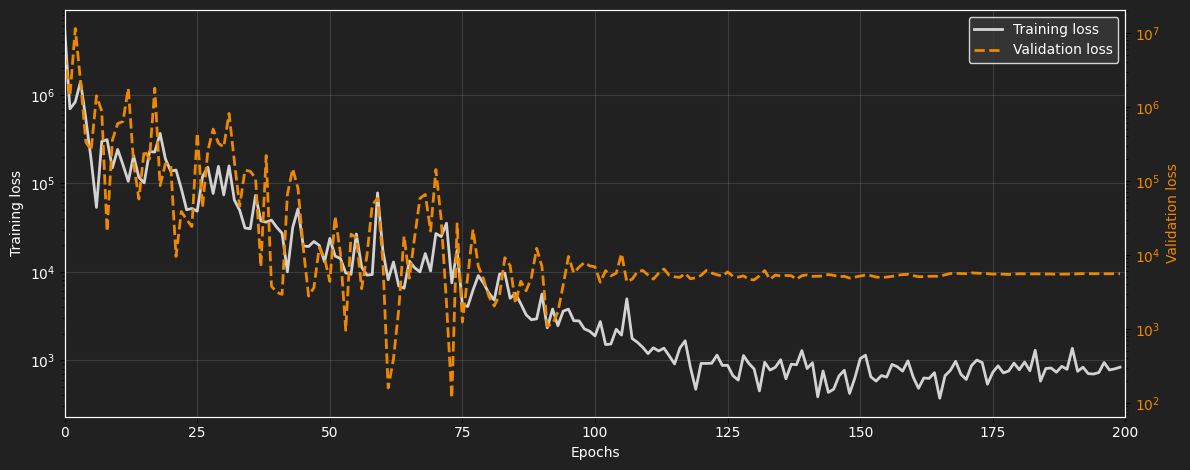

In [6]:
## Plot Losses
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#loss_np = np.array(losses[1:])
loss_np = pd.read_csv('training_loss_gatconv_1117_norm.csv',index_col=0,header=1).to_numpy()

plt, ax1 = plt.subplots()
plt.set_figwidth(12)
plt.patch.set_facecolor('#212121')
ax1.set_facecolor('#212121')  
ax1.grid(alpha=0.2)
x = np.arange(0,loss_np.shape[0])
ax1.plot(x, loss_np[:,0], label='Training loss', linewidth=2,color='white',alpha=0.8)
ax1.set_xlabel('Epochs',color='white')
#ax1.set_ylim(8000,15000)
ax1.set_ylabel('Training loss', color='white')
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelcolor='white')
ax1.tick_params(axis='y', labelcolor='white')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, loss_np[:,1], color='#ee8800', label='Validation loss', linewidth=2, linestyle='--')
#ax2.set_ylim(2000,5000)
ax2.set_yscale('log')
ax2.set_ylabel('Validation loss', color='#ee8800')
ax2.tick_params(axis='y', labelcolor='#ee8800')

for spine in ax1.spines.values():
    spine.set_color('white')
for spine in ax2.spines.values():
    spine.set_color('white')


ax1.set_xlim(0,200)
# Optional: combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', facecolor='#3a3a3a', edgecolor='white', labelcolor='white')
plt.tight_layout()
plt.show()

In [5]:
## Validation Cases
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Material encoding (1-h)
def load_material_vocab() -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV: idx,label
    #df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP'] #0,1,2,3 fixed material labels for now
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    return vocab

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def incidence_edges_from_conn(conn: np.ndarray, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    node_tensor = nodes.to(edge_index.device)
    conn_tensor = torch.from_numpy(conn).long().to(edge_index.device)
    #edge attribute -> mesh to element centroid in xyz
    elem_nodes = node_tensor[conn_tensor]
    centroids = elem_nodes.mean(dim=1, keepdim=True)
    rel_disp = (elem_nodes - centroids).reshape(-1, elem_nodes.size(-1))

    return edge_index, rel_disp



# Connectivity
# mesh nodes <-> mesh nodes
# mesh nodes <-> element nodes

def data_to_graph(path:str,device):
    data = HeteroData()
    vocab = load_material_vocab()
    simdata = torch.load(path,weights_only=False)
    conn = simdata["elements"]
    conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
    nodes = simdata['nodes']
    label = simdata['material']
    c2n_ei, c2n_w = incidence_edges_from_conn(conn,nodes)  # [2, E_cn], [E_cn, 1]
    
    # mesh node properties: positions, internal forces, BC, dirichlet displacement
    data['nodes'].pos = nodes #                                             [N,3]
    data['nodes'].f_ext = simdata['ext_forces'] #external forces            [T,N,3]
    data['nodes'].bc = simdata['boundary'] #                                [N,3]
    #data['nodes'].dr = simdata['dirichlet_disp'] #dirichlet displacement   [N,3]

    # element node properties: material, stiffness matrix
    data['elements'].material = one_hot(label, vocab, device=device).unsqueeze(0).repeat(int(conn.shape[0]), 1) # [E,len(materials)]
    #data['elements'].stiffness = #stiffness is a learned feature

    # target properties
    # mesh: displacement over time
    # element: stress, damage state, internal forces
    data['nodes'].u_ts = simdata['u_history'] #                                     [T,N,3]
    data['elements'].s_ts = simdata['stress_history'] #                             [T,E,3]
    data['elements'].d_ts = simdata['state']
    data['nodes'].f_int = simdata['forces'] #internal forces in timeseries format     [T,N,3]

    # edges: connectivity mesh-mesh, mesh-element
    # mesh-element: distance to element centroid
    data["elements", "contributes", "nodes"].edge_index = c2n_ei
    data["elements", "contributes", "nodes"].edge_attr = c2n_w
    data["nodes", "belongs_to", "elements"].edge_index = c2n_ei.flip(0)
    data["nodes", "belongs_to", "elements"].edge_attr = c2n_w.flip(0)
    data['elements'].num_nodes = simdata['stress_history'].size(1)

    # mesh-mesh: distance
    ei = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["nodes", "adjacent", "nodes"].edge_index = ei
    data["nodes", "adjacent_rev", "nodes"].edge_index = ei.flip(0)
    data["nodes", "adjacent", "nodes"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    #data['elements'].edge_index = simdata['elements'] #mesh-element [E,8]
    #data['nodes'].edge_index = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1)) #from stiffness matrix, only connectivity

    # for debugging dimensions
    #print(data['nodes'].num_nodes)                              # N
    #print(data['elements'].num_nodes)                           # E
    #print(data.num_edges)                                       # 2*((E*num_vertices)+())
    #print(data['nodes','adjacent','nodes'].num_edges)           # 
    #print(data['nodes','adjacent_rev','nodes'].num_edges)       #
    #print(data['elements','contributes','nodes'].num_edges)     # E*num_vertices
    #print(data['nodes','belongs_to','elements'].num_edges)      # E*num_vertices

    #data = data.pin_memory()
    data = data.to(device)
    return data

#data_to_graph('../torchfem_dataset/panel_plasticity_2/simulation_dump_3.pt',device)

device = torch.device('cpu')
data_dir = '../torchfem_dataset/panel_plasticity_2/'
files = (Path(data_dir).glob("simulation_dump_15*.pt"))
samples = []
for file in files:
    if '150' in str(file):
        continue
    data = data_to_graph(file,device)
    samples.append(data)
    print(file)
#print(len(files))


..\torchfem_dataset\panel_plasticity_2\simulation_dump_151.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_152.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_153.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_154.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_155.pt


In [91]:
torch.save(samples, "../base/test_dataset/test_combined.pt")

In [ ]:
## Predictions from trained model - HGT

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader

device = torch.device('cpu')
#samples = torch.load("../base/test_dataset/test_combined.pt",weights_only=False)
samples = torch.load("../torchfem_dataset/panel_plasticity_3/panel_combined.pt",weights_only=False)
samples_2 = torch.load("../torchfem_dataset/tube_2/tube_combined.pt",weights_only=False)

## Process dataset for training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data, dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes â†’ u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts
    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        elem_s = torch.cat([d['elements'].y_s.float() for d in dataset],dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    e = data[etype].edge_attr.float()
                    self.edge_stats[etype] = {
                        "mean": e.mean(dim=0, keepdim=True),
                        "std":  e.std(dim=0, keepdim=True) + 1e-8}
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            "mean": node_u.mean(dim=0, keepdim=True),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['elem_s'] = {
            "mean": elem_s.mean(dim=0, keepdim=True),
            "std":  elem_s.std(dim=0, keepdim=True) + 1e-8}
        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x
        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u
        y_s = data['elements'].y_s.float()
        m_s = self.node_stats['elem_s']["mean"]
        s_s = self.node_stats['elem_s']["std"]
        data['elements'].y_s = (y_s - m_s) / s_s

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: dict):
        # Nodes
        m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data['u'] = data["u"] * s + m

        m, s = self.node_stats["nodes_f"]["mean"], self.node_stats["nodes_f"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data["fint"] = data["fint"] * s + m

        m, s = self.node_stats["elem_s"]["mean"], self.node_stats["elem_s"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data["s"] = data["s"] * s + m

        return data

scaler = HeteroStandardScaler()

## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in (samples+samples_2)]
scaler.fit(dataset_p)
samples_dataset = [scaler.transform(d) for d in dataset_p]

## HGT Model
class HGTMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_u    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes â†’ u
        self.head_fint = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes â†’ f_int
        self.head_s    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 9))   # elements â†’ s (3x3)
        #self.head_d    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 1))   # elements â†’ d (optional)

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict); x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)

        h_nodes    = x['nodes']
        h_elements = x['elements']

        pred_u    = self.head_u(h_nodes)
        pred_fint = self.head_fint(h_nodes)
        pred_s    = self.head_s(h_elements)
        #pred_d    = self.head_d(h_elements)  # you can ignore this if d is missing

        return {'u': pred_u, 'fint': pred_fint, 's': pred_s}#, 'd': pred_d}
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = samples_dataset[0].metadata()
in_dims = {
    'nodes':    samples_dataset[0]['nodes'].x.size(-1),
    'elements': samples_dataset[0]['elements'].x.size(-1),
}

model = HGTMultipleOutput(metadata, in_dims, hidden=64, heads=2).to(device)
model_state = torch.load('hgt_multitask_best_1117_norm.pt')
model.load_state_dict(model_state)
model.eval()

sample_loader   = DataLoader(samples_dataset, batch_size=1, shuffle=True)
sample = next(iter(sample_loader))
batch = sample.to(device)
#print(batch['nodes'].keys())
pred = model(batch.x_dict, batch.edge_index_dict)
#pred = [scaler.inverse_transform(d) for d in pred]

In [2]:
## Predictions from trained model - GAT

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, HeteroConv
from torch_geometric.loader import DataLoader

device = torch.device('cpu')
#samples = torch.load("../base/test_dataset/test_combined.pt",weights_only=False)
samples = torch.load("../torchfem_dataset/panel_plasticity_3/panel_combined.pt",weights_only=False)
#samples_2 = torch.load("../torchfem_dataset/tube_2/tube_combined.pt",weights_only=False)

## Process dataset for training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data, dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext, pos], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes â†’ u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts
    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        elem_s = torch.cat([d['elements'].y_s.float() for d in dataset],dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    e = data[etype].edge_attr.float()
                    self.edge_stats[etype] = {
                        "mean": e.mean(dim=0, keepdim=True),
                        "std":  e.std(dim=0, keepdim=True) + 1e-8}
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            "mean": node_u.mean(dim=0, keepdim=True),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['elem_s'] = {
            "mean": elem_s.mean(dim=0, keepdim=True),
            "std":  elem_s.std(dim=0, keepdim=True) + 1e-8}
        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x
        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u
        y_s = data['elements'].y_s.float()
        m_s = self.node_stats['elem_s']["mean"]
        s_s = self.node_stats['elem_s']["std"]
        data['elements'].y_s = (y_s - m_s) / s_s

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: dict):
        # Nodes
        m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data['u'] = data["u"] * s + m

        m, s = self.node_stats["nodes_f"]["mean"], self.node_stats["nodes_f"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data["fint"] = data["fint"] * s + m

        m, s = self.node_stats["elem_s"]["mean"], self.node_stats["elem_s"]["std"]
        m = m.to(data['u'].device);  s = s.to(data['u'].device)
        data["s"] = data["s"] * s + m

        return data

scaler = HeteroStandardScaler()

## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in samples]
scaler.fit(dataset_p)
samples_dataset = [scaler.transform(d) for d in dataset_p]

## GAT Model
class HeteroGATMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()

        self.metadata = metadata
        node_types, edge_types = metadata

        # ---- Input linear layers ----
        self.lin_in = nn.ModuleDict({
            'nodes':    nn.Linear(in_dims['nodes'], hidden),
            'elements': nn.Linear(in_dims['elements'], hidden),
        })

        # ---- Build hetero convolution layers using GATConv ----
        # First MP layer
        conv1_dict = {}
        for src, rel, dst in edge_types:
            conv1_dict[(src, rel, dst)] = GATConv(
                in_channels=hidden,
                out_channels=hidden // heads,
                heads=heads,
                add_self_loops=False
            )
        self.conv1 = HeteroConv(conv1_dict, aggr='sum')

        # Second MP layer
        conv2_dict = {}
        for src, rel, dst in edge_types:
            conv2_dict[(src, rel, dst)] = GATConv(
                in_channels=hidden,
                out_channels=hidden // heads,
                heads=heads,
                add_self_loops=False
            )
        self.conv2 = HeteroConv(conv2_dict, aggr='sum')

        # ---- Output heads ----
        self.head_u    = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 3))
        self.head_fint = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 3))
        self.head_s    = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 9))


    def forward(self, x_dict, edge_index_dict):

        # Encode input
        x = {k: F.relu(self.lin_in[k](v)) for k, v in x_dict.items()}

        # --- First GAT layer ---
        x = self.conv1(x, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}

        # --- Second GAT layer ---
        x = self.conv2(x, edge_index_dict)

        # Split types
        h_nodes    = x['nodes']
        h_elements = x['elements']

        return {
            'u':    self.head_u(h_nodes),
            'fint': self.head_fint(h_nodes),
            's':    self.head_s(h_elements),
        }
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = samples_dataset[0].metadata()
in_dims = {
    'nodes':    samples_dataset[0]['nodes'].x.size(-1),
    'elements': samples_dataset[0]['elements'].x.size(-1),
}

model = HeteroGATMultipleOutput(metadata, in_dims, hidden=128, heads=2).to(device)
model_state = torch.load('gatconv_1118_norm.pt')
model.load_state_dict(model_state)
model.eval()

sample_loader   = DataLoader(samples_dataset, batch_size=1, shuffle=True)
sample = next(iter(sample_loader))
batch = sample.to(device)
#print(batch['nodes'].keys())
pred = model(batch.x_dict, batch.edge_index_dict)
#pred = [scaler.inverse_transform(d) for d in pred]

In [3]:
from copy import deepcopy

out_samples = []
with torch.no_grad():
    for i, data in enumerate(samples_dataset):
        d = deepcopy(data)         # keep originals intact
        d = d.to(device)

        pred = model(d.x_dict, d.edge_index_dict)  # returns dict: {'u','fint','s'}
        pred = scaler.inverse_transform(pred)

        # Detach and move predictions to CPU for saving
        pu = pred['u'].detach().cpu()
        pf = pred['fint'].detach().cpu()
        ps = pred['s'].detach().cpu()

        # Move the data structure back to CPU before attaching CPU tensors
        d = d.to('cpu')

        # Attach predictions into the dictionary
        d['nodes'].pred_u = pu
        d['nodes'].pred_fint = pf
        d['elements'].pred_s = ps

        out_samples.append(d)

# Save to a new file
save_path = "../base/test_dataset/test_combined_with_preds_gatconv_1118.pt"
torch.save(out_samples, save_path)
print(f"Saved {len(out_samples)} samples with predictions to {save_path}")

Saved 87 samples with predictions to ../base/test_dataset/test_combined_with_preds_gatconv_1118.pt


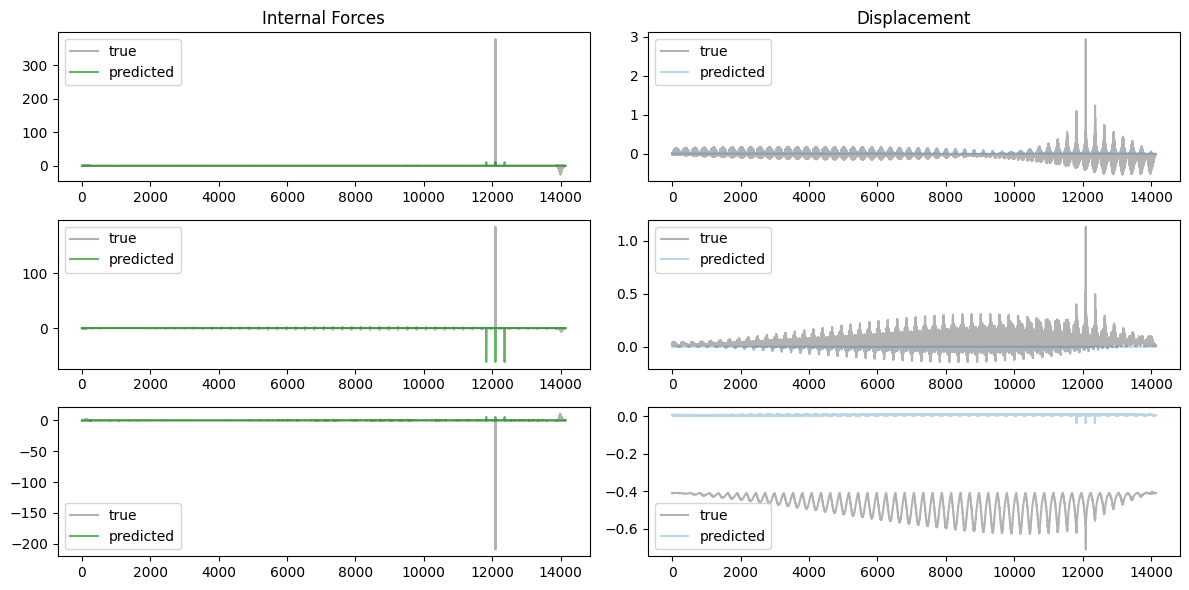

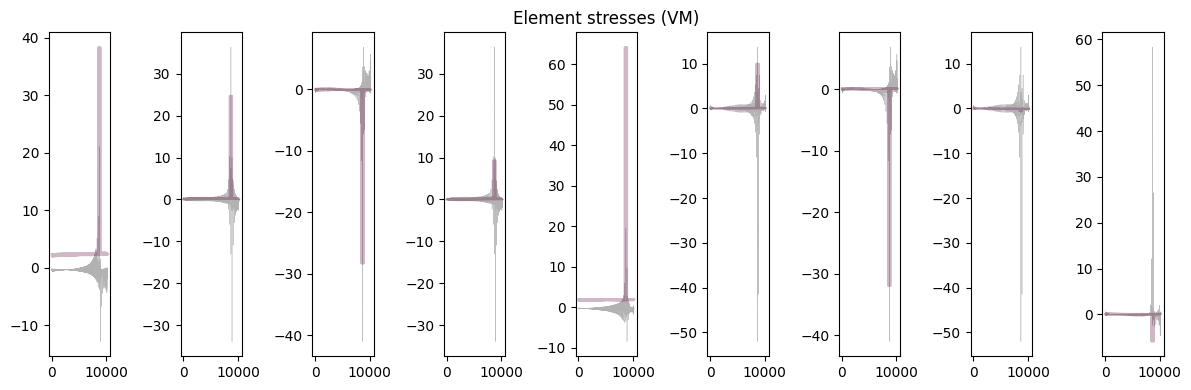

In [26]:
import matplotlib.pyplot as plt
import torch
out_samples = torch.load("../base/test_dataset/test_combined_with_preds_gatconv_1118.pt",weights_only=False)

fig, ax = plt.subplots(3,2)
fig.set_figwidth(12)
fig.set_figheight(6)
sample = 54

ax[0,0].set_title('Internal Forces')
ax[0,1].set_title('Displacement')

for i in range(3):
    ax[i,1].plot(out_samples[sample]['nodes']['y_u'][:,i],'k',alpha=0.3,label='true')
    ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:,i],alpha=0.3,label='predicted')
    ax[i,1].legend()
    
    ax[i,0].plot(out_samples[sample]['nodes']['y_fint'][:,i],'k',alpha=0.3,label='true')
    ax[i,0].plot(out_samples[sample]['nodes']['pred_fint'][:,i],color='green',alpha=0.6,label='predicted')
    ax[i,0].legend()
plt.tight_layout()


fig, ax = plt.subplots(1,9)
fig.set_figwidth(12)
fig.set_figheight(4)
ax[4].set_title('Element stresses (VM)')
for i in range(9):
    ax[i].plot(out_samples[sample]['elements']['y_s'][:,i],'k',linewidth=0.3,alpha=0.3)
    ax[i].plot(out_samples[sample]['elements']['pred_s'][:,i],color='#661144',alpha=0.3)
plt.tight_layout()


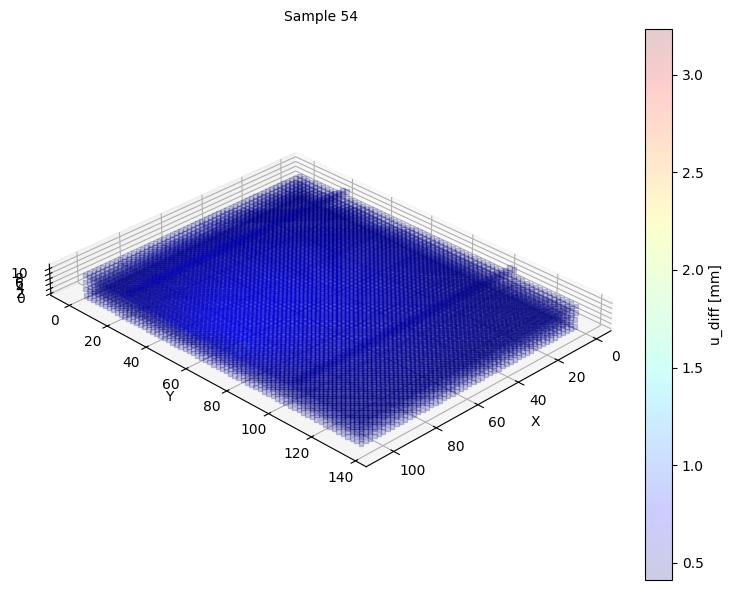

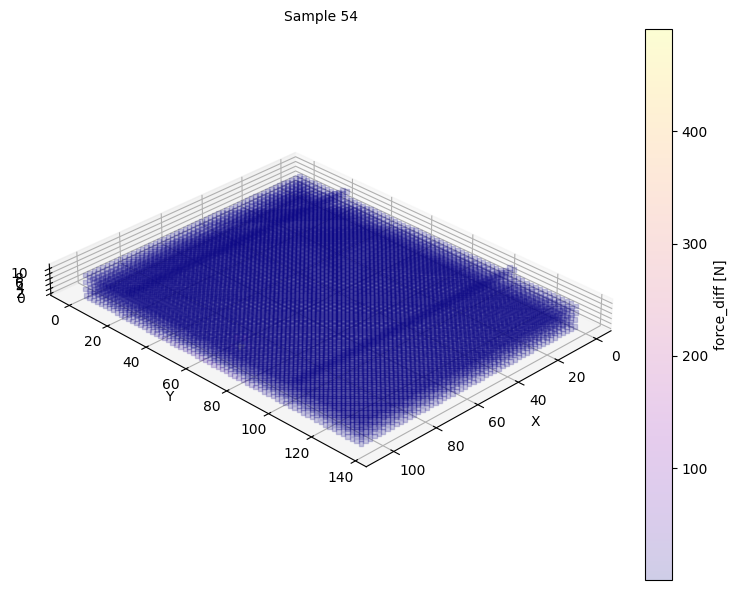

In [27]:
## Visualization - Matplotlib 3D Scatter Plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Sample {sample}',fontsize=10)

#sc = ax.scatter(out_samples[sample]['nodes']['pos'],'k',alpha=0.3,label='initial position')
#ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:],alpha=0.3,label='predicted')

#ax.plot_trisurf(V[:,0],V[:,1],V[:,2],triangles=F,edgecolor='#888888',linewidth=lw,antialiased=True,color='#dddddd',alpha=0.1)

vis_scale = 1

pos_init = out_samples[sample]['nodes']['pos']
pos_true = pos_init+out_samples[sample]['nodes']['y_u']*vis_scale
pos_pred = pos_init+out_samples[sample]['nodes']['pred_u']*vis_scale
pos_diff = np.linalg.norm(pos_true-pos_pred,axis=-1)

force_true = out_samples[sample]['nodes']['y_fint']
force_pred = out_samples[sample]['nodes']['pred_fint']
force_diff = np.linalg.norm(force_true-force_pred,axis=-1)

#sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=2,marker='s',c='#1111dd',alpha=0.2,depthshade=True)
#sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)
#sc3 = ax.scatter(pos_pred[:,0],pos_pred[:,1],pos_pred[:,2],s=2,marker='s',c='#dd1111',alpha=0.2,depthshade=True)
sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=10,marker='s',c=pos_diff,cmap='jet',alpha=0.2,depthshade=True)
plt.colorbar(sc, ax=ax, label='u_diff [mm]')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=30, azim=45)
ranges = np.ptp(out_samples[sample]['nodes']['pos'].T, axis=1)
ax.set_box_aspect(ranges)

plt.tight_layout()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title(f'Sample {sample}',fontsize=10)

sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=10,marker='s',c=force_diff,cmap='plasma',alpha=0.2,depthshade=True)
plt.colorbar(sc, ax=ax, label='force_diff [N]')
#sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=30, azim=45)
ranges = np.ptp(out_samples[sample]['nodes']['pos'].T, axis=1)
ax.set_box_aspect(ranges)

plt.tight_layout()

In [30]:
from collections import Counter
import pyvista as pv
from collections import defaultdict
import numpy as np

vis_scale = 200

pos = out_samples[sample]['nodes']['pos'].cpu().numpy()        # (N,3)
edges = out_samples[sample][('nodes','adjacent','nodes')]['edge_index'].T.cpu().numpy()
pos_true = pos+(out_samples[sample]['nodes']['y_u']*vis_scale).cpu().numpy()
pos_pred = pos+(out_samples[sample]['nodes']['pred_u']*vis_scale).cpu().numpy()
print(out_samples[sample]['elements'].x[0])

adj = defaultdict(set)
for i, j in edges:
    adj[i].add(j)
    adj[j].add(i)

def find_quad_faces(adj):
    faces = set()

    for a in adj:
        for b in adj[a]:
            for c in adj[b]:
                if c == a: continue
                for d in adj[c]:
                    if d in adj[a] and d not in (a,b,c):    # closes the loop
                        quad = tuple(sorted([a,b,c,d]))
                        faces.add(quad)

    return np.array(list(faces))

faces = find_quad_faces(adj)

# Count duplicates
face_counts = Counter([tuple(sorted(f)) for f in faces])

surface_faces = np.array([f for f, c in face_counts.items() if c == 1])


# Convert to VTK-style quad faces
faces_pv = np.hstack([
    np.concatenate([[4], face]) for face in surface_faces
])

mesh = pv.PolyData(pos_pred, faces_pv)

mesh.plot(
    show_edges=False,
    color="#8fa7ff",
    smooth_shading=False,
    opacity=0.95,
)


tensor([0., 1., 0., 0.])


Widget(value='<iframe src="http://localhost:49506/index.html?ui=P_0x2574ec2daf0_6&reconnect=auto" class="pyvisâ€¦

6529.688736637018 -3.185553210105496e-11 -7.36733590800398e-11 6.379291539460041e-11
-3.185553210105496e-11 -7.36733590800398e-11 6529.688736637081
0.0 0.0 6529.688736637017


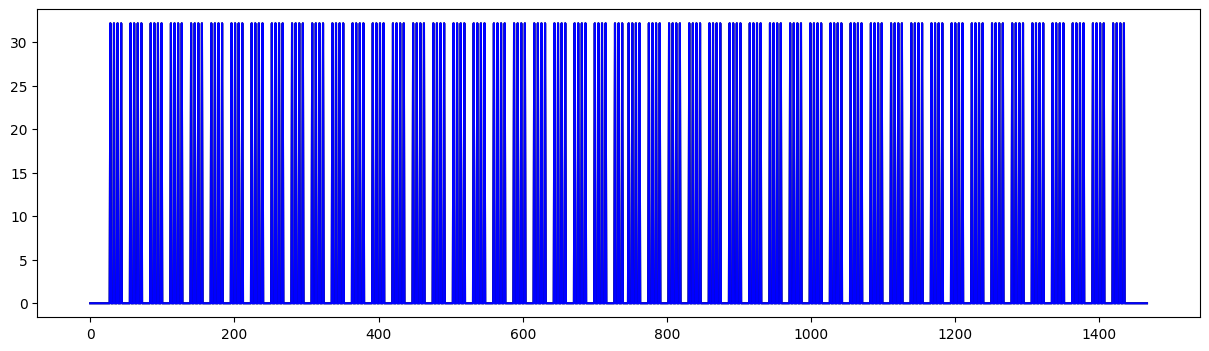

In [192]:
import torch
import numpy as np
import matplotlib.pyplot as plt

sim = torch.load('../base/euler_dataset/panel_plasticity_2/simulation_dump_4.pt')
fint = sim['forces'].detach().cpu().numpy()
fext = sim['ext_forces']
t = 15

mask = sim['boundary']

fint = fint[:,~mask[:,0]]
fext = fext[:,~mask[:,0]]
ext_t = fext[t].sum()
x_eq = (fint[t,:,0]-fext[t,:,0]).sum()
y_eq = (fint[t,:,1]-fext[t,:,1]).sum()
z_eq = (fint[t,:,2]-fext[t,:,2]).sum()
print(ext_t,x_eq,y_eq,z_eq)
print(fint[t,:,0].sum(),fint[t,:,1].sum(),fint[t,:,2].sum())
print(fext[t,:,0].sum(),fext[t,:,1].sum(),fext[t,:,2].sum())

residual = fint[t]+fext[t]

#print(sim['stiffness'].shape,sim['nodes'].shape,sim['elements'].shape)
#print(sim['elements'][0])
#print(sim['nodes'][sim['elements'][0]])
V = sim['nodes']
F = sim['elements']
plt.figure(figsize=(15,4))
#plt.xlim(0,200)
plt.plot(fint[t,:,2],'k')
plt.plot(fext[t,:,2],'b')

#F = torch.column_stack([F,F[:,0]])
#F_edges = np.unique(np.sort(torch.vstack([F[:,i:i+2] for i in range(8)]),axis=1),axis=0)

def mesh_edges_from_conn(conn: torch.Tensor) -> torch.Tensor:
    conn = conn.long()                             # [E, nverts]
    hex_edges = torch.tensor([
        [0,1], [1,2], [2,3], [3,0],     # bottom face
        [4,5], [5,6], [6,7], [7,4],     # top face
        [0,4], [1,5], [2,6], [3,7],     # vertical edges
    ])
    pairs = conn[:, hex_edges]          # [E, 12, 2]
    pairs = pairs.reshape(-1, 2)
    pairs = torch.unique(torch.sort(pairs, dim=1).values, dim=0)
    edge_index = torch.cat([pairs, pairs.flip(1)], dim=0).T
    #edge_index = pairs.T
    return edge_index

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

#F_edges = stiffness_to_node_adj_edge_index(K=sim['stiffness'],num_nodes=0,dof_per_node=3)
#F_edges = mesh_edges_from_conn(F)
#count = (F_edges==127).sum()
# per element: 12 edges, 8 nodes
# per node: 3 -> 6 connections
